In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# 15.3 시계열 예측하기   
RNN 모델을 이용해 예측할 시계열을 임의로 만들어보자.

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) 
    time = np.linspace(0, 1, n_steps) # 타임 스텝 길이의 직선
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

(3, 10, 1)


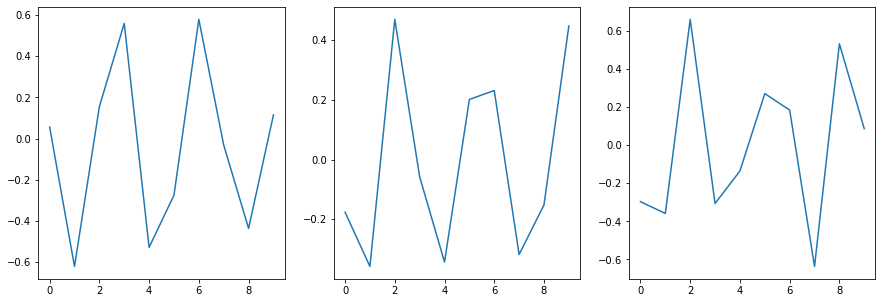

In [ ]:
# 생성된 단변량 시계열 예시로 그려보기
batch_size_test = 3
time_step_test = 10

series_test = generate_time_series(batch_size_test, time_step_test)
print(series_test.shape)

flg, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
  axes[i].plot(series_test[i, :, :])
plt.show()

In [ ]:
n_steps = 50 
series = generate_time_series(10000, n_steps + 1)
series.shape

(10000, 51, 1)

In [ ]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [ ]:
X_valid.shape, y_valid.shape

((2000, 50, 1), (2000, 1))

In [ ]:
X_test.shape, y_test.shape

((1000, 50, 1), (1000, 1))

## 15.3.1 기준 성능(Baseline Performance)

### 순진한(단순한) 예측    
마지막 값을 예측, 실제(다음) 값과 비교

In [ ]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.019851077

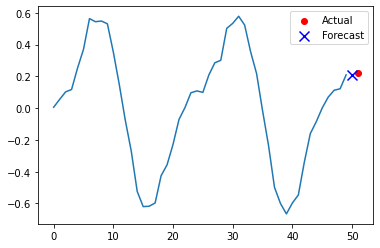

In [ ]:
plt.plot(X_valid[0, :, 0])
plt.scatter(n_steps+1, y_valid[0, 0], c='r', label='Actual')
plt.scatter(n_steps, y_pred[0, 0], marker='x', s=100, c='b', label='Forecast')
plt.legend(fontsize=10)
plt.show()

### 선형회귀 모델 예측    
FC layer  네트워크

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0820 - val_loss: 0.0273
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0162
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0156 - val_loss: 0.0121
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0101
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0073
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0064
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0049

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 943us/step - loss: 0.0038


0.0037688903976231813

## 15.3.2 간단한 RNN 구현하기

Simple RNN 모델     
- 하나의 뉴런(층)으로 이루어진
- tanh 
- 모델 파라미터 = 3

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, return_sequences=False, input_shape=[None, 1])
])
print(model.summary())

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.0899 - val_loss: 0.0682
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0630 - val_loss: 0.0487
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0441 - val_loss: 0.0334
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0307 - val_loss: 0.0226
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0209 - val_loss: 0.0161
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0158 - val_loss: 0.0130
Epoch 7/20
219/219 [============================

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0108


0.010824398137629032

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(1, input_shape=(3, 1), return_sequences=True)) # Time step=3
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 3, 1)              3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


## 15.3.3 Deep RNN    
- 셀을 여러 층으로 쌓은 심층 RNN 모델

In [ ]:
# SimpleRNN(유닛 또는 은닉 상태의 크기=20)에서 '20'은 출력  차원의 수와 같다.
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
model.summary()

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 7s 24ms/step - loss: 0.0422 - val_loss: 0.0045
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.00

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0029


0.0028892492409795523

### 마지막 층의 은닉 상태 제거    
하나의 값만 출력하면 된다! 마지막 층에서 굳이 순환할 필요는 없다    
- Dense layer 사용
- 새로운 활성화 함수 사용 가능
- 정확도도 조금 더 좋고 속도 또한 훨씬 빠르다


In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # return_sequences 제거 -> 은닉 상태 제거
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 17ms/step - loss: 0.0229 - val_loss: 0.0046
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 7/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 8/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 10/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0031 - val_lo

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0031


0.0030830444302409887

## 15.3.4 여러 타임 스텝 앞을 예측하기

### 방법 1) 한 번에 1스텝씩 10스텝 앞을 예측하기

In [ ]:
series = generate_time_series(1, n_steps + 10) # 타임스텝=50+10 = 60
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new


In [ ]:
# 하나의 값을 예측하는 모델로 하나의ㅣ 값씩 총 10개 예측
# 1~50일 -> 51일 예측, 2~51일->52일 예측, ..... 10~59일->60일 예측
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [ ]:
Y_pred

array([[[ 0.38628387],
        [ 0.47545967],
        [ 0.55171984],
        [ 0.5707417 ],
        [ 0.5311678 ],
        [ 0.4202601 ],
        [ 0.24182405],
        [ 0.04602697],
        [-0.15402451],
        [-0.3297839 ]]], dtype=float32)

In [ ]:
np.mean(keras.metrics.mean_squared_error(Y_new, Y_pred))

0.049755923

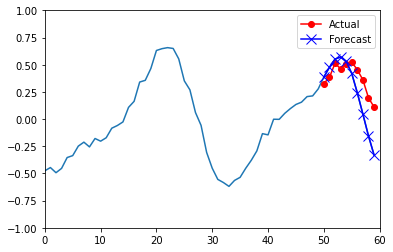

In [ ]:
plt.plot(X[0, :, 0])
plt.plot(np.arange(n_steps, n_steps + 10), Y_new[0, :, 0], "ro-", label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
plt.axis([0, n_steps + 10, -1, 1])
plt.legend(fontsize=10)
plt.show()

### 방법 2) 다음 갓 10개를 한 번에 예측    
- 50개의 타임 스텝을 이용하여 다음 10개의 타임 스텝 값 예측
- 타깃 = 10개의 타임  스텝 값을 지닌 벡터
- 0 ~ 49->50 ~ 59

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10) # 타이므텝=50+10
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0] #  Y 타깃을 마지막 10개의 값으로 설
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 10))

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # return_sequences 제거 -> 은닉 상태 제거
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 17ms/step - loss: 0.1838 - val_loss: 0.1451
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.1470 - val_loss: 0.1443
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.1418 - val_loss: 0.1448
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.1485 - val_loss: 0.1437
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.1468 - val_loss: 0.1441
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.1453 - val_loss: 0.1437
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.1490 - val_loss: 0.1439
Epoch 8/20
219/219 [==============================] - 3s 15ms/step - loss: 0.1445 - val_loss: 0.1437
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.1466 - val_loss: 0.1437
Epoch 10/20
219/219 [==============================] - 3s 15ms/step - loss: 0.1463 - val_lo

In [ ]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 4ms/step - loss: 0.1393


0.13929371535778046

### 방법 3) 모든 타임 스텝에서 다음 값 10개 예측하기     
- 시퀀스-to-시퀀스 RNN으로변경
- 타임 스텝 0 -> 1 ~ 10
- 타입 스텝 1 -> 2 ~ 11
- .....
- 타임 스텝 49 -> 50~59


In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10) # 60 타임스텝
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
Y = np.empty((10000, n_steps, 10))

# 타임 스텝 0 -> 1 ~ 10 ...
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

Y_train.shape

(7000, 50, 10)

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True), # return_sequences 추가 -> 시퀀스 to 시퀀스 모델
    keras.layers.TimeDistributed(keras.layers.Dense(10)) # 모든 타임 스텝에서 출력을 적용하기 위해 사용
])

# 마지막 타임 스텝의 출력에 대한 MSE만 사용
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 19ms/step - loss: 0.0650 - last_time_step_mse: 0.0569 - val_loss: 0.0422 - val_last_time_step_mse: 0.0289
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0384 - last_time_step_mse: 0.0264 - val_loss: 0.0320 - val_last_time_step_mse: 0.0195
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0313 - last_time_step_mse: 0.0186 - val_loss: 0.0270 - val_last_time_step_mse: 0.0133
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0278 - last_time_step_mse: 0.0156 - val_loss: 0.0255 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0257 - last_time_step_mse: 0.0141 - val_loss: 0.0247 - val_last_time_step_mse: 0.0115
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0225 - last_time_step_mse: 0.0098 - val_loss: 0.0249 - val_last_time_step_mse: 0.0137
Epoch 7/20
219/219 [==

In [ ]:
model.evaluate(X_test, y_test)

# 15.4 긴 시퀀스 다루기    
- 타임 스텝 증가 -> 매우 깊은 네트워크
- 문제 1: 그래디언트 소실 & 폭주
- 문제 2: 장기 기억 불가

## 15.4.1 불안정한 그레이디언트 문제와 싸우기   
- 수렴하지 않는 활성화 함수(ex.ReLU)는 오히려 성능 약화
- 배치 정규화 -> 성능 그저 그렇다
- 층 정규화 -> 효과적이

### 배치 정규화 층

In [ ]:
# 순환 층 사이에 배치 정규화 층 추가하기, 타임 스텝 상에는?
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 19ms/step - loss: 0.7019 - last_time_step_mse: 0.6882 - val_loss: 0.0829 - val_last_time_step_mse: 0.0775
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0635 - last_time_step_mse: 0.0511 - val_loss: 0.0526 - val_last_time_step_mse: 0.0436
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0484 - last_time_step_mse: 0.0370 - val_loss: 0.0466 - val_last_time_step_mse: 0.0371
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0444 - last_time_step_mse: 0.0332 - val_loss: 0.0420 - val_last_time_step_mse: 0.0308
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0407 - last_time_step_mse: 0.0290 - val_loss: 0.0400 - val_last_time_step_mse: 0.0275
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0373 - last_time_step_mse: 0.0243 - val_loss: 0.0392 - val_last_time_step_mse: 0.0259
Epoch 7/20
219/219 [==

In [ ]:
model.evaluate(X_test, y_test)

### 층 정규화    
- 특성 차원에 대한 정규화
- 메모리 셀 안에 층 정규화
- 타임 스텝 (순환 중 내부, 즉 수평 방향)마다 적용
- 속도는 아무래도 느리다..

In [ ]:
from tensorflow.keras.layers import LayerNormalization

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units # 은닉 상태
        self.output_size = units # 출력 상태
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None) # 활성화 함수 삭제
        self.layer_norm = LayerNormalization() # 내부에서 층 정규화
        self.activation = keras.activations.get(activation) # 활성화 함수 추가 # 층 정규화 + 활성화 함수 적용
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 11s 40ms/step - loss: 0.2672 - last_time_step_mse: 0.2572 - val_loss: 0.0724 - val_last_time_step_mse: 0.0653
Epoch 2/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0649 - last_time_step_mse: 0.0531 - val_loss: 0.0582 - val_last_time_step_mse: 0.0444
Epoch 3/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0566 - last_time_step_mse: 0.0441 - val_loss: 0.0550 - val_last_time_step_mse: 0.0430
Epoch 4/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0525 - last_time_step_mse: 0.0406 - val_loss: 0.0496 - val_last_time_step_mse: 0.0366
Epoch 5/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0481 - last_time_step_mse: 0.0359 - val_loss: 0.0491 - val_last_time_step_mse: 0.0360
Epoch 6/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0467 - last_time_step_mse: 0.0340 - val_loss: 0.0507 - val_last_time_step_mse: 0.0405
Epoch 7/20
219/219 [=

## 15.4.2 단기 기억 문제 해결하기     
- 장기 메모리를 가진 여러 종류의 셀 (LSTM, GRU)

### LSTM(Long Short Term Memoory) 셀    
- 장기 상태에 저장할 것, 버릴 것, 읽어들일 것을 학습하는 셀
- 장기 상태에 저장, 보존, 추출
- 장기 패턴 파악에 효과

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 11s 38ms/step - loss: 0.1043 - last_time_step_mse: 0.0954 - val_loss: 0.0533 - val_last_time_step_mse: 0.0335
Epoch 2/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0492 - last_time_step_mse: 0.0274 - val_loss: 0.0400 - val_last_time_step_mse: 0.0182
Epoch 3/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0383 - last_time_step_mse: 0.0165 - val_loss: 0.0342 - val_last_time_step_mse: 0.0137
Epoch 4/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0336 - last_time_step_mse: 0.0136 - val_loss: 0.0319 - val_last_time_step_mse: 0.0134
Epoch 5/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0314 - last_time_step_mse: 0.0126 - val_loss: 0.0301 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0300 - last_time_step_mse: 0.0122 - val_loss: 0.0293 - val_last_time_step_mse: 0.0124
Epoch 7/20
219/219 [=

### GRU(Gate Recurrent Unit) 셀
- LSTM 변종
- 간소화된 버전

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

### 1D 합성곱 층을 사용해 시퀀스 처리하기
- 여전히 긴 길이의 데이터에 대해서 기억하지 모하는 문제 존재
- 입력 시퀀스를 짧게 줄이기 위해 1D 합성곱 사용

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2])) # 타깃을 3부터 시작, 2배 다운 샘플링

In [ ]:
model.evaluate(X_test, Y_test[:, 3::2])

### WAVENET
- 음성을 고품질로 합성해내기 위한 모델
- 층마다 팽창 비율을 두 배로  늘리는 1D 합성곱 층
- 하위층을 단기 패턴, 상위층은 장기 패턴
- 여러 오디오 문제에서 최상의 성능 보임
- 'Casual' Padding

In [40]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate)) # dilation_rate = 팽창비율
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.summary()
# model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          60        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 20)         